uncomment if executing in google colab

In [1]:
# ! pip uninstall pyro-ppl
# ! pip install pyro-ppl==1.5.1
# ! unzip fonts.zip 
# ! unzip claptchagen.zip
# ! unzip csis
# ! cp csis.py /usr/local/lib/python3.7/dist-packages/pyro/infer

In [2]:
import random
import string
import os
import torch.nn as nn
import torch
import torch.nn.functional as F
import pyro
import numpy as np
import pyro.optim as optim
import pyro.distributions as dist
import pyro.infer
import pyro.optim
import time

from torch.autograd import Variable
from pyro.infer import SVI, Trace_ELBO, TraceGraph_ELBO
from PIL import Image
from claptchagen.claptcha import Claptcha
from torch.distributions import constraints
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from gmade import GMADE
import matplotlib.pyplot as plt
print(pyro.__version__)

captcha_folder = 'generated_captchas'
captchaHeight = 24
captchaWidth = 60
captchaMarginX = 2.5
captchaMarginY = 2.5
batch_size = 10

char_dict = string.digits
char_dict = "abc"
USE_CUDA = True
#MAX_N = 4 # maximum number of letters in a captcha 
#MIN_N = 2 # minimum number of letters in a captcha
MAX_N = 4
MIN_NOISE = 0.003921569 # minimum noise 1./255.
MAX_NOISE = 0.8 # maximum noise
smoke_test = False
num_steps = 300 if not smoke_test else 10
TrainingSample = 500 if not smoke_test else 100 # number of captchas generated for training 
hidden_state_dim = 32
blend_alpha_min = 0.6
blend_alpha_max = 0.99
blend_alpha = 0.6

def randomString():
    """
    return a string with <num_char> random letters
    """
    #k = random.randint(MIN_N, MAX_N) # sample number of characters
    k = MAX_N
    
    rndLetters = (random.choice(char_dict) for _ in range(k))
    
    pad_spaces = MAX_N - k # pad the string so the captcha is close to center
    space = " " * (pad_spaces // 2)
    return space + "".join(rndLetters) + space

def emptyString():
    """
    return a string with <num_char> random letters
    """
    #k = random.randint(MIN_N, MAX_N) # sample number of characters
    k = MAX_N
    
    rndLetters = (random.choice(char_dict) for _ in range(k))
    
    pad_spaces = MAX_N - k # pad the string so the captcha is close to center
    space = " " * (pad_spaces // 2)
    return " " * MAX_N

def ramdomNoise():
    """
    return a float between MIN_NOISE, MAX_NOISE
    """
    #return random.uniform(0.85, MAX_NOISE)
    return random.uniform(MIN_NOISE, MAX_NOISE)
def generate_noise(noise_seed):
    return np.maximum(np.minimum(np.round(255 * ((1- noise_seed) + 0.25 * np.random.randn(captchaHeight, captchaWidth))), 255), 0)
    
def generate_random_captcha(n, save=False):
    """
    generate n random captchas,
    return a list of texts on the captchas
    """
    # Initialize Claptcha object with random text, FreeMono as font, of size
    # 100x30px, using bicubic resampling filter and adding a bit of white noise
    c = Claptcha(randomString, "fonts/FreeSans.ttf", (captchaWidth, captchaHeight), (captchaMarginX, captchaMarginY),
             resample=Image.BILINEAR, noise=0)
    captcha_generated = [ [] for i in range(MAX_N)]
    for i in range(n):
        #c2.noise = ramdomNoise()
        if save:
            text, _ = c.write(os.path.join(captcha_folder, 'captcha{}.png'.format(i)))
            os.rename(os.path.join(captcha_folder, 'captcha{}.png'.format(i)),os.path.join(captcha_folder, '{}.png'.format(text + "_" + str(i))))
        text, image = c.image
        noise_seed = ramdomNoise()
        noise_image = generate_noise(noise_seed)
        #_, noise_image = c2.image
        text = text.strip()
        image = np.array(image)[:, :, 0] # the generator is gray scale, only keep one channel is enough
        blend_alpha = random.uniform(blend_alpha_min, blend_alpha_max)
        blend_image = image * blend_alpha + (1-blend_alpha) * noise_image
        captcha_generated[len(text) - 1].append((text, image.astype(int), noise_image.astype(int), blend_image.astype(int), noise_seed, blend_alpha))
    return captcha_generated
    
captcha_generated = generate_random_captcha(TrainingSample, save=False)
for lst in captcha_generated:
    print("number of samples in group", len(lst))
    # print some sample captcha information generated
    for i, t in enumerate(lst):
        print("text", t[0], "captcha shape", t[3].shape, "noise", t[4], "blend_alpha", t[5])
        if i >= 10:
            break

1.7.0
number of samples in group 0
number of samples in group 0
number of samples in group 0
number of samples in group 500
text ccbc captcha shape (24, 60) noise 0.2588960246077299 blend_alpha 0.9010155584252488
text cbbc captcha shape (24, 60) noise 0.6481333495606816 blend_alpha 0.9842123162880735
text caac captcha shape (24, 60) noise 0.3715459464452176 blend_alpha 0.6655517206345855
text cbaa captcha shape (24, 60) noise 0.7972738184517436 blend_alpha 0.9412568060935995
text cccc captcha shape (24, 60) noise 0.4752706651183633 blend_alpha 0.8521745085573221
text aacc captcha shape (24, 60) noise 0.32479686521733103 blend_alpha 0.8255087807604893
text bbac captcha shape (24, 60) noise 0.6530671324773217 blend_alpha 0.6015522404782603
text ccaa captcha shape (24, 60) noise 0.4587264390013689 blend_alpha 0.7644175221692391
text abac captcha shape (24, 60) noise 0.2408315259042953 blend_alpha 0.8942101298922943
text abcb captcha shape (24, 60) noise 0.35633987496921793 blend_alpha 0.6

text ccbc noise 0.2588960246077299 blend_alpha 0.9010155584252488


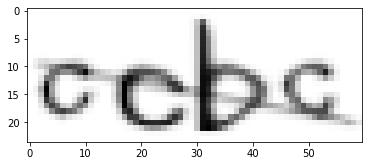

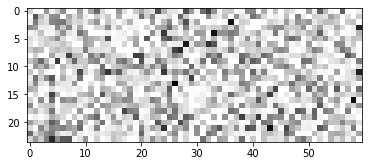

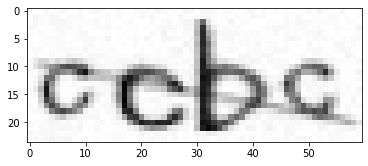

text cbbc noise 0.6481333495606816 blend_alpha 0.9842123162880735


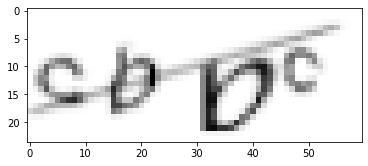

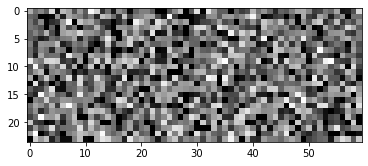

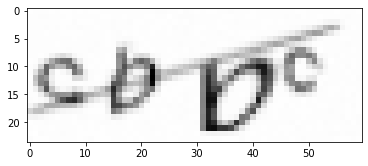

text caac noise 0.3715459464452176 blend_alpha 0.6655517206345855


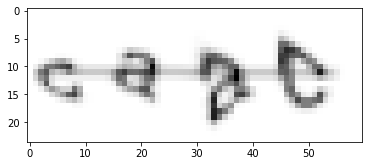

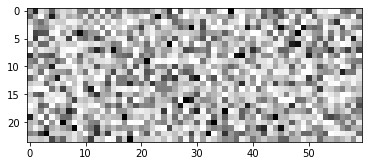

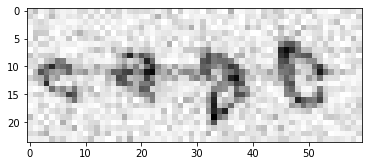

In [3]:
import sys
np.set_printoptions(threshold=sys.maxsize)
for lst in captcha_generated:
    for i in range(3):
        if len(lst) > 0:
            print("text", lst[i][0], "noise", lst[i][4], "blend_alpha", lst[i][5])
            plt.imshow(255-lst[i][1], cmap="Greys")
            plt.show()
            #print(255-lst[0][1])
            plt.imshow(255-lst[i][2], cmap="Greys")
            plt.show()
            #print(255 - lst[0][2])
            #plt.imshow(np.round((255-lst[0][2]) * blend_alpha + (255-lst[0][1]) * (1- blend_alpha)), cmap="Greys")
            plt.imshow(255-lst[i][3], cmap="Greys")
            plt.show()
            #print(np.minimum(255, (255-lst[0][2] + 255-lst[0][1])))

In [4]:
def render_image(chars, fonts="fonts/FreeSans.ttf", size=(captchaWidth, captchaHeight), 
                 margin=(captchaMarginX, captchaMarginY), resample=Image.BILINEAR, noise=0.3, use_cuda=False):
    pad_spaces = MAX_N - len(chars)
    space = " " * (pad_spaces // 2)
    chars = space + chars + space
    render = Claptcha(chars, fonts, size, margin, resample=resample, noise=noise)

    _ , rendered_image = render.image
    rendered_image = np.array(rendered_image)[:,:,0] # the generator is gray scale, only keep one channel is enough
    rendered_image = np.subtract(np.divide(rendered_image, 255), 0.5)
    rendered_image = torch.from_numpy(rendered_image)
    if use_cuda:
        rendered_image = rendered_image.cuda()
    return rendered_image

In [5]:
class CaptchaDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, raw_captchas, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.raw_captchas = raw_captchas
        self.transform = transform

    def __len__(self):
        return len(self.raw_captchas)

    def __getitem__(self, idx):
        label = self.raw_captchas[idx][0]
        char_image = self.raw_captchas[idx][1]
        noise_image = self.raw_captchas[idx][2]
        blend_image = self.raw_captchas[idx][3]
        noise = self.raw_captchas[idx][4]
        blend_alpha = self.raw_captchas[idx][5]
        
        blend_image = np.subtract(np.divide(blend_image, 255), 0.5)
        blend_image = torch.from_numpy(blend_image).float()

        if self.transform:
            blend_image = self.transform(blend_image)

        return label, blend_image, noise, blend_alpha

In [6]:
def make_loarders(BATCH_SIZE, raw_samples):
    dataloaders = [] # dataloaders for different num of char
    for lst in raw_samples:
        if lst:
            ds = CaptchaDataset(lst)
            dataloader = DataLoader(ds, batch_size=BATCH_SIZE,
                                    shuffle=True, num_workers=0, drop_last=True)
            dataloaders.append(dataloader)
    return dataloaders

def make_batches(dataloaders):
    all_batches = []
    for dl in dataloaders:
        for i_batch, sample in enumerate(dl):
            all_batches.append(sample)
    random.shuffle(all_batches)
    random.shuffle(all_batches)
    return all_batches

TrainLoaders = make_loarders(BATCH_SIZE=batch_size, raw_samples=captcha_generated)

In [7]:
class NoiseAlphaNet(nn.Module):

    def __init__(self, img_size, out_size = 1):
        """
        Network for learning noise in a captcha
        """
        super(NoiseAlphaNet, self).__init__()
        
        self.img_size = img_size
        self.fc1 = nn.Linear(img_size[0] * img_size[1], 1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.fc3 = nn.Linear(1024, out_size)
        self.softplus = nn.Softplus()
    
    def forward(self, img):
        BS = img.shape[0]
        img = img.reshape(-1, self.img_size[0] * self.img_size[1]).float()
        hidden = self.fc1(img)
        mean = self.fc3(F.relu(self.fc2(F.relu(hidden))))
        sigma = torch.tensor([[1e-8] for _ in range(BS)]).float()
        if USE_CUDA:
            sigma = sigma.cuda()
        return mean, sigma, hidden

In [8]:
# not used
class NumNet(nn.Module):
    def __init__(self, img_size, out_size = 3):
        """
        Network for learning N, number of letters in a captcha
        """
        super(NumNet, self).__init__()
        self.neural_net = nn.Sequential(
            nn.Linear(img_size[0] * img_size[1], img_size[0] * img_size[1] * 2),
            nn.ReLU(),
            nn.Linear(img_size[0] * img_size[1] * 2, 256),
            nn.ReLU(),
            nn.Linear(256, out_size),
            nn.LogSoftmax(dim=1))
  
    def forward(self, img):
        img = torch.reshape(img, (img.shape[0], img.shape[1] * img.shape[2]))
        prob = self.neural_net(img)
        return prob

In [9]:
# not used
class InputEmbedding(nn.Module):
    def __init__(self, img_size, output_size, MAX_N):
        """
        Network for letters in a captcha, given the noise and number of letters
        """
        super(InputEmbedding, self).__init__()
        self.img_size = img_size
        
        # observe layers
        self.nnfc = nn.Linear(img_size[0] * img_size[1], img_size[0] * img_size[1])
        self.conv1 = nn.Conv2d(1, 64, 3)
        self.conv2 = nn.Conv2d(64, 64, 3)
        self.conv3 = nn.Conv2d(64, 64, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.convBN1 = nn.BatchNorm2d(64)
        self.convBN2 = nn.BatchNorm2d(64)
        self.convBN3 = nn.BatchNorm2d(64)

    def forward(self, img, noise_map):
        
        BATCH_SIZE = img.shape[0]
        img = torch.reshape(img, (BATCH_SIZE, 1, self.img_size[0], self.img_size[1]))

        img = self.pool(F.relu(self.convBN1(self.conv1(img))))
        img = self.pool(F.relu(self.convBN2(self.conv2(img))))
        img = self.pool(F.relu(self.convBN3(self.conv3(img))))
        
        img = torch.reshape(img, (BATCH_SIZE, 1280))
        return img

In [10]:
class ChannelExtract(nn.Module):

    def __init__(self, img_size, out_size = 1):
        """
        Network for learning noise in a captcha
        """
        super(ChannelExtract, self).__init__()
        
        self.img_size = img_size
        self.fc0 = nn.Linear(img_size[0] * img_size[1] + 1, img_size[0] * img_size[1] * 2)
        self.fc1 = nn.Linear(img_size[0] * img_size[1] * 2, img_size[0] * img_size[1] * 2)
        self.fc2 = nn.Linear(img_size[0] * img_size[1] * 2, img_size[0] * img_size[1])
        
    def forward(self, img, alpha):
        BS = img.shape[0]
        img = img.reshape(-1, self.img_size[0] * self.img_size[1]).float()
        img = torch.cat([img, alpha], 1)
        hidden = F.relu(self.fc1(F.relu(self.fc0(img))))
        hidden = self.fc2(hidden)
        hidden = torch.reshape(hidden, (BS, self.img_size[0], self.img_size[1]))
        sigma = torch.tensor(1e-5)
        if USE_CUDA:
            sigma = sigma.cuda()
        sigma = sigma.repeat(BS, self.img_size[0], self.img_size[1])
        #print("sigma", sigma.shape)
        return hidden, sigma

In [11]:
class NoiseChannelExtract(nn.Module):

    def __init__(self, img_size, out_size = 1):
        """
        Network for learning noise in a captcha
        """
        super(NoiseChannelExtract, self).__init__()
        
        self.img_size = img_size
        self.fc0 = nn.Linear(img_size[0] * img_size[1] + 1, img_size[0] * img_size[1] * 2)
        self.fc1 = nn.Linear(img_size[0] * img_size[1] * 2, img_size[0] * img_size[1] * 2)
        self.fc2 = nn.Linear(img_size[0] * img_size[1] * 2, img_size[0] * img_size[1] * 2)
        
        self.fc_loc = nn.Linear(img_size[0] * img_size[1] * 2, img_size[0] * img_size[1])
        self.fc_sig = nn.Linear(img_size[0] * img_size[1] * 2, img_size[0] * img_size[1])
        self.softplus = nn.Softplus()
    
    def forward(self, img, alpha):
        BS = img.shape[0]
        img = img.reshape(-1, self.img_size[0] * self.img_size[1]).float()
        img = torch.cat([img, alpha], 1)
        hidden = F.relu(self.fc1(F.relu(self.fc0(img))))
        hidden = F.relu(self.fc2(hidden))
        loc = self.fc_loc(hidden)
        sig = self.softplus(self.fc_sig(hidden))
        loc = torch.reshape(loc, (BS, self.img_size[0], self.img_size[1]))
        sig = torch.reshape(sig, (BS, self.img_size[0], self.img_size[1])) 
        return loc, sig

In [12]:
class CharNetSingle(nn.Module):
    def __init__(self, img_size, output_size, MAX_N):
        """
        Network for letters in a captcha, given the noise and number of letters
        """
        super(CharNetSingle, self).__init__()
        self.img_size = img_size
        
        # branches
        self.pfc1 = nn.Linear(img_size[0] * img_size[1] + hidden_state_dim + 1, 2048)
        self.pfc2 = nn.Linear(2048, 1024)
        self.pfc3 = nn.Linear(1024, 1024)
        self.pfc4 = nn.Linear(1024, output_size)

    def forward(self, img, hid, noise_batch):
        
        BATCH_SIZE = img.shape[0]
        img = img.reshape(-1, self.img_size[0] * self.img_size[1]).float()
        img = torch.cat((img, hid, noise_batch), 1)
        
        out = F.relu(self.pfc1(img))
        out = F.relu(self.pfc2(out))
        out = F.relu(self.pfc3(out))
        out = self.pfc4(out)
        out = F.log_softmax(out, dim=1)
        
        return out

In [13]:
class simpleNN(nn.Module):
    def __init__(self, input_size=1, hidden=32, out_size=1, t="normal", out_non_linear=None):
        super().__init__()
        self.t = t
        self.out_non_linear = out_non_linear
        self.hiddeen_layer = nn.Linear(input_size, hidden)
        if t == "normal":
            self.loc_layer = nn.Linear(hidden, out_size)
            self.std_layer = nn.Linear(hidden, out_size)
            self.softplus = nn.Softplus()
        elif t == "bern":
            self.prob_layer = nn.Linear(hidden, out_size)
        elif t == "mlp":
            self.out_layer = nn.Linear(hidden, out_size)
        
    def forward(self, x_list):
        for i in range(len(x_list)):
            if x_list[i].dim() == 0:
                x_list[i] = torch.unsqueeze(x_list[i], dim=0)
        input_x = torch.cat(x_list, 1)
        #print(input_x, input_x.shape)
        hid = F.relu(self.hiddeen_layer(input_x))
        # return loc, std
        if self.t == "normal":
            return self.loc_layer(hid), self.softplus(self.std_layer(hid))
        elif self.t == "bern":
            return torch.sigmoid(self.prob_layer(hid))
        else:
            if self.out_non_linear == "tanh":
                return torch.tanh(self.out_layer(hid))
            else:
                return self.out_layer(hid)

In [14]:
def inference(t, use_cuda=False):
    """
    one epoch of inference (iterate the training set once)
    """
    start = time.time()
    loss = 0
    length = TrainingSample
    loss_group = []
    all_batches = make_batches(TrainLoaders)
    for i_batch, sample_batched in enumerate(all_batches):
        img = sample_batched[1]
        if use_cuda:
            img = img.cuda()
        IMG = {"captcha" : img}
        imme_loss = csis.step(observations=IMG)
        loss += imme_loss / length

    print("loss at epoch {} is {}".format(t, loss), end="; ")
    print("Epoch takes", round(time.time()- start), "seconds")
    return loss

In [15]:
test_accuracies = []
test_char_accuracies = []
test_noise_differences = []
test_alpha_differences = []
train_accuracies = []
train_char_accuracies = []
train_noise_differences = []
train_alpha_differences = []
def test(n = 0, use_train=False, verbose=False, use_cuda=False):
    """
    benchmarking performance on customized or training set
    """
    global test_accuracies, test_char_accuracies, test_noise_differences, test_alpha_differences
    global train_accuracies, train_char_accuracies, train_noise_differences, train_alpha_differences
    if use_train:
        TestLoaders = make_loarders(BATCH_SIZE=1, raw_samples=captcha_generated)
    else:
        test_captcha_generated = generate_random_captcha(n, save=False)
        TestLoaders = make_loarders(BATCH_SIZE=1, raw_samples=test_captcha_generated)
    
    total_correct = 0
    char_correct = 0
    total_char = 0
    all_batches = make_batches(TestLoaders)
    noise_difference = 0
    alpha_difference = 0
    for i_batch, t in enumerate(all_batches):

        label = t[0][0]
        img = t[1]
        gt_noise = t[2][0]
        gt_alpha = t[3][0]

        if use_cuda:
            img = img.cuda()
        
        IMG = {"captcha" : img}
        
        posterior = csis.run(observations=IMG)
        marginal_noise = pyro.infer.EmpiricalMarginal(posterior, "noise")
        marginal_alpha = pyro.infer.EmpiricalMarginal(posterior, "alpha")
        with torch.no_grad():
            #N_index = marginal_num()
            #N = N_index + captchaModel.num_char_domain[0]
            noise = captchaModel._map_to_noise_range(marginal_noise()[0])
            alpha = captchaModel._map_to_alpha_range(marginal_alpha()[0])
            sampled_chars = []
            
            # sample characters one by one
            for i in range(MAX_N):
                marginal_char = pyro.infer.EmpiricalMarginal(posterior, "char_{}".format(i))()[0]
                if use_cuda:
                    marginal_char.cpu()
                sampled_chars.append(marginal_char)
        
        chars = ""
        for i in range(len(sampled_chars)):
            c = sampled_chars[i]
            chars +=  captchaModel.char_dict[c]
        correct = 0
        
        for p_char, t_char in zip(chars, label):
            if p_char == t_char:
                correct += 1
        noise_difference += abs(float(noise) - float(gt_noise))
        alpha_difference += abs(float(alpha) - float(gt_alpha))
        N = MAX_N
        if not verbose:
            print("N_predicted:", int(N), "| Actual N:", len(label), "| Predicted Noise:", round(float(noise), 3), "| Actual Noise:", round(float(gt_noise), 3), "| Predicted Alpha:", round(float(alpha), 3), "| Actual Alpha:", round(float(gt_alpha), 3), "| Predicted Text:", chars, "| Actual Text:", label, "| Correct:", correct)
        if correct == len(label) and int(N) == len(label):
            total_correct += 1
        char_correct += correct
        total_char += len(label)
    num_test_samples = i_batch + 1
    accuracy = total_correct / num_test_samples
    char_accuracy = char_correct / total_char
 
    
    noise_difference = noise_difference / num_test_samples
    alpha_difference = alpha_difference / num_test_samples
    if use_train:
        train_accuracies.append(accuracy)
        train_char_accuracies.append(char_accuracy)
        train_noise_differences.append(noise_difference)
        train_alpha_differences.append(alpha_difference)
    elif n > 10:
        test_accuracies.append(accuracy)
        test_char_accuracies.append(char_accuracy)
        test_noise_differences.append(noise_difference)
        test_alpha_differences.append(alpha_difference)
    print("use_train =", use_train, "AVG Noise Difference:", noise_difference, "AVG Alpha Difference:", alpha_difference, "Total correct:", total_correct, "accuracy:{}/{}=".format(total_correct, num_test_samples), accuracy, "char_accuracy:{}/{}=".format(char_correct, total_char), char_accuracy)


In [16]:

losses  = []
def test_cycle(use_cuda):
    
    # disable dropout
#     captchaModel.numNet.eval()
#     captchaModel.charNetSingle.eval()
    test(use_train=True, verbose=True, use_cuda=use_cuda)
    test(1000, use_train=False, verbose=True, use_cuda=use_cuda)
    #test(10, use_train=True, verbose=False, use_cuda=use_cuda)
    test(10, use_train=False, verbose=False, use_cuda=use_cuda)
    # enable dropout
#     captchaModel.numNet.train()
#     captchaModel.charNetSingle.train()

def optimize(start_epoch=1, use_cuda=False):
    """
    Training/Inferencing Stage
    """
    loss_sequence = []
    pause = 5
    save_pause = 10
    print("Optimizing...")
    for t in range(start_epoch, num_steps + 1):
        L = inference(t, use_cuda)
        loss_sequence.append(L)
        losses.append(L)
        if (t % pause == 0) and (t > 0):
            test_cycle(use_cuda=use_cuda)
        #if (t % save_pause == 0) and (t > 0):
        #    save_and_download_checkpoints("branches-1-no-var-no-tanh_model.pt", "branches-1-no-var-no-tanh_optim.pt", "branches-1-no-var-no-tanh_param_store.pt")
    plt.plot(loss_sequence)
    plt.title("loss")
    plt.show()

In [17]:
# saves the model and optimizer states to disk
def save_checkpoint(currentModel, currentOptimzier, save_model, save_opt, save_param_store):
    print("saving model to %s..." % save_model)
    torch.save(currentModel.state_dict(), save_model)
    print("saving optimizer states to %s..." % save_opt)
    currentOptimzier.save(save_opt)
    print("saving pyro pram store states to %s..." % save_param_store)
    pyro.get_param_store().save(save_param_store)
    print("done saving checkpoints to disk.")

# loads the model and optimizer states from disk
def load_checkpoint(myModel, myOptimzer, load_model, load_opt, load_param_store):
    pyro.clear_param_store()
    print("loading model from %s..." % load_model)
    myModel.load_state_dict(torch.load(load_model))
    print("loading optimizer states from %s..." % load_opt)
    myOptimzer.load(load_opt)
    print("loading pyro pram store states from %s..." % load_param_store)
    pyro.get_param_store().load(load_param_store)
    print("done loading states.")
    pyro.module("guide", myModel, update_module_params=True)

def save_and_download_checkpoints(save_model, save_opt, save_param_store):
    save_checkpoint(captchaModel, optimiser, save_model, save_opt, save_param_store)
def save_metric_to_disk(file_path):
    import json
    save_dict = {
        "test_accuracies" : test_accuracies,
        "test_char_accuracies" : test_char_accuracies,
        "test_noise_differences" : test_noise_differences,
        "test_alpha_differences" : test_alpha_differences,
        "train_accuracies"  : train_accuracies,
        "train_char_accuracies"  : train_char_accuracies,
        "train_noise_differences" : train_noise_differences,
        "train_alpha_differences" : train_alpha_differences,
    }
    with open(file_path, 'w') as fout:
        json.dump(save_dict, fout)

Optimizing...
loss at epoch 1 is 1496236309676629.0; Epoch takes 20 seconds
loss at epoch 2 is 560158609989841.5; Epoch takes 19 seconds
loss at epoch 3 is 249092427193146.66; Epoch takes 19 seconds
loss at epoch 4 is 203838090455204.94; Epoch takes 19 seconds
loss at epoch 5 is 176795557503465.5; Epoch takes 19 seconds
use_train = True AVG Noise Difference: 0.16329099277284664 AVG Alpha Difference: 0.10909933636555617 Total correct: 6 accuracy:6/500= 0.012 char_accuracy:650/2000= 0.325
use_train = False AVG Noise Difference: 0.17405999149973236 AVG Alpha Difference: 0.10298791019526321 Total correct: 8 accuracy:8/1000= 0.008 char_accuracy:1324/4000= 0.331
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.404 | Actual Noise: 0.51 | Predicted Alpha: 0.88 | Actual Alpha: 0.86 | Predicted Text: cbab | Actual Text: babb | Correct: 1
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.401 | Actual Noise: 0.011 | Predicted Alpha: 0.861 | Actual Alpha: 0.625 | Predicted Text: cabc | Actual Text

use_train = False AVG Noise Difference: 0.18293256686621992 AVG Alpha Difference: 0.105918224091117 Total correct: 17 accuracy:17/1000= 0.017 char_accuracy:1322/4000= 0.3305
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.482 | Actual Noise: 0.409 | Predicted Alpha: 0.878 | Actual Alpha: 0.819 | Predicted Text: caba | Actual Text: bcca | Correct: 1
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.615 | Actual Noise: 0.744 | Predicted Alpha: 0.858 | Actual Alpha: 0.735 | Predicted Text: baac | Actual Text: acaa | Correct: 1
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.472 | Actual Noise: 0.046 | Predicted Alpha: 0.875 | Actual Alpha: 0.728 | Predicted Text: caca | Actual Text: ccbc | Correct: 1
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.444 | Actual Noise: 0.037 | Predicted Alpha: 0.871 | Actual Alpha: 0.757 | Predicted Text: ccab | Actual Text: aabb | Correct: 1
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.576 | Actual Noise: 0.507 | Predicted Alpha: 0.877 | Actual 

N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.492 | Actual Noise: 0.228 | Predicted Alpha: 0.874 | Actual Alpha: 0.824 | Predicted Text: accb | Actual Text: cabb | Correct: 1
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.466 | Actual Noise: 0.142 | Predicted Alpha: 0.886 | Actual Alpha: 0.918 | Predicted Text: cabb | Actual Text: aaaa | Correct: 1
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.518 | Actual Noise: 0.158 | Predicted Alpha: 0.879 | Actual Alpha: 0.886 | Predicted Text: abcc | Actual Text: aacc | Correct: 3
use_train = False AVG Noise Difference: 0.25044987289987714 AVG Alpha Difference: 0.08781173637018637 Total correct: 0 accuracy:0/10= 0.0 char_accuracy:11/40= 0.275
loss at epoch 36 is 115680197430737.42; Epoch takes 24 seconds
loss at epoch 37 is 110670229421565.56; Epoch takes 29 seconds
loss at epoch 38 is 116064931304972.08; Epoch takes 43 seconds
loss at epoch 39 is 102526526391954.06; Epoch takes 25 seconds
loss at epoch 40 is 105633856306266.78; Epoch 

loss at epoch 51 is 97814229491201.05; Epoch takes 41 seconds
loss at epoch 52 is 100208886307282.42; Epoch takes 45 seconds
loss at epoch 53 is 99318430720812.5; Epoch takes 52 seconds
loss at epoch 54 is 100887567266848.86; Epoch takes 46 seconds
loss at epoch 55 is 103437552380259.97; Epoch takes 42 seconds
use_train = True AVG Noise Difference: 0.1562689659871631 AVG Alpha Difference: 0.11352130960897001 Total correct: 43 accuracy:43/500= 0.086 char_accuracy:1100/2000= 0.55
use_train = False AVG Noise Difference: 0.15675008741464527 AVG Alpha Difference: 0.10767227421614581 Total correct: 145 accuracy:145/1000= 0.145 char_accuracy:2287/4000= 0.57175
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.455 | Actual Noise: 0.316 | Predicted Alpha: 0.878 | Actual Alpha: 0.856 | Predicted Text: babc | Actual Text: aabc | Correct: 3
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.665 | Actual Noise: 0.778 | Predicted Alpha: 0.874 | Actual Alpha: 0.82 | Predicted Text: cbac | Actual Text:

use_train = False AVG Noise Difference: 0.1536131456472078 AVG Alpha Difference: 0.11084126740066554 Total correct: 237 accuracy:237/1000= 0.237 char_accuracy:2707/4000= 0.67675
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.354 | Actual Noise: 0.059 | Predicted Alpha: 0.871 | Actual Alpha: 0.603 | Predicted Text: bcab | Actual Text: baab | Correct: 3
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.422 | Actual Noise: 0.537 | Predicted Alpha: 0.878 | Actual Alpha: 0.901 | Predicted Text: bacb | Actual Text: bcbc | Correct: 1
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.407 | Actual Noise: 0.174 | Predicted Alpha: 0.876 | Actual Alpha: 0.787 | Predicted Text: acab | Actual Text: acab | Correct: 4
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.452 | Actual Noise: 0.386 | Predicted Alpha: 0.864 | Actual Alpha: 0.651 | Predicted Text: abca | Actual Text: acac | Correct: 1
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.371 | Actual Noise: 0.195 | Predicted Alpha: 0.869 | Act

N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.543 | Actual Noise: 0.795 | Predicted Alpha: 0.866 | Actual Alpha: 0.807 | Predicted Text: acaa | Actual Text: acaa | Correct: 4
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.437 | Actual Noise: 0.37 | Predicted Alpha: 0.863 | Actual Alpha: 0.624 | Predicted Text: abac | Actual Text: abab | Correct: 3
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.42 | Actual Noise: 0.263 | Predicted Alpha: 0.881 | Actual Alpha: 0.989 | Predicted Text: cbcb | Actual Text: ccca | Correct: 2
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.577 | Actual Noise: 0.673 | Predicted Alpha: 0.857 | Actual Alpha: 0.667 | Predicted Text: cbba | Actual Text: cbba | Correct: 4
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.379 | Actual Noise: 0.145 | Predicted Alpha: 0.876 | Actual Alpha: 0.872 | Predicted Text: cbac | Actual Text: cbac | Correct: 4
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.491 | Actual Noise: 0.273 | Predicted Alpha: 0.879 | Actu

N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.494 | Actual Noise: 0.458 | Predicted Alpha: 0.871 | Actual Alpha: 0.818 | Predicted Text: cabb | Actual Text: caab | Correct: 3
use_train = False AVG Noise Difference: 0.15791398359519254 AVG Alpha Difference: 0.08189201690955339 Total correct: 4 accuracy:4/10= 0.4 char_accuracy:33/40= 0.825
loss at epoch 101 is 87787246189767.38; Epoch takes 35 seconds
loss at epoch 102 is 86847391986887.44; Epoch takes 35 seconds
loss at epoch 103 is 89904686822421.4; Epoch takes 41 seconds
loss at epoch 104 is 81796001534158.44; Epoch takes 40 seconds
loss at epoch 105 is 92983929363775.48; Epoch takes 40 seconds
use_train = True AVG Noise Difference: 0.15143231493009746 AVG Alpha Difference: 0.11125134088223042 Total correct: 226 accuracy:226/500= 0.452 char_accuracy:1609/2000= 0.8045
use_train = False AVG Noise Difference: 0.15450898791846882 AVG Alpha Difference: 0.1053583635240442 Total correct: 463 accuracy:463/1000= 0.463 char_accuracy:3252/40

loss at epoch 116 is 87942230440974.8; Epoch takes 38 seconds
loss at epoch 117 is 90624220192595.36; Epoch takes 36 seconds
loss at epoch 118 is 83336809377621.9; Epoch takes 35 seconds
loss at epoch 119 is 82266886034917.69; Epoch takes 38 seconds
loss at epoch 120 is 79166525864800.5; Epoch takes 38 seconds
use_train = True AVG Noise Difference: 0.1569318207915497 AVG Alpha Difference: 0.11040155346533655 Total correct: 247 accuracy:247/500= 0.494 char_accuracy:1651/2000= 0.8255
use_train = False AVG Noise Difference: 0.16403784599078297 AVG Alpha Difference: 0.10711435014273732 Total correct: 489 accuracy:489/1000= 0.489 char_accuracy:3313/4000= 0.82825
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.491 | Actual Noise: 0.43 | Predicted Alpha: 0.865 | Actual Alpha: 0.739 | Predicted Text: cbab | Actual Text: cbab | Correct: 4
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.397 | Actual Noise: 0.053 | Predicted Alpha: 0.875 | Actual Alpha: 0.885 | Predicted Text: bacb | Actual T

use_train = False AVG Noise Difference: 0.16087052980676528 AVG Alpha Difference: 0.10766213405704989 Total correct: 489 accuracy:489/1000= 0.489 char_accuracy:3292/4000= 0.823
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.275 | Actual Noise: 0.049 | Predicted Alpha: 0.878 | Actual Alpha: 0.678 | Predicted Text: cbcb | Actual Text: cbab | Correct: 3
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.435 | Actual Noise: 0.163 | Predicted Alpha: 0.88 | Actual Alpha: 0.918 | Predicted Text: aabb | Actual Text: aabb | Correct: 4
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.5 | Actual Noise: 0.724 | Predicted Alpha: 0.867 | Actual Alpha: 0.794 | Predicted Text: baca | Actual Text: aacb | Correct: 2
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.511 | Actual Noise: 0.67 | Predicted Alpha: 0.857 | Actual Alpha: 0.639 | Predicted Text: bbca | Actual Text: bbca | Correct: 4
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.4 | Actual Noise: 0.728 | Predicted Alpha: 0.864 | Actual Alp

N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.466 | Actual Noise: 0.716 | Predicted Alpha: 0.872 | Actual Alpha: 0.835 | Predicted Text: bcbc | Actual Text: bcbc | Correct: 4
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.525 | Actual Noise: 0.567 | Predicted Alpha: 0.863 | Actual Alpha: 0.672 | Predicted Text: bbbb | Actual Text: bbaa | Correct: 2
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.484 | Actual Noise: 0.647 | Predicted Alpha: 0.851 | Actual Alpha: 0.612 | Predicted Text: abbb | Actual Text: abbb | Correct: 4
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.386 | Actual Noise: 0.088 | Predicted Alpha: 0.882 | Actual Alpha: 0.904 | Predicted Text: aacb | Actual Text: aacb | Correct: 4
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.402 | Actual Noise: 0.437 | Predicted Alpha: 0.858 | Actual Alpha: 0.616 | Predicted Text: aaba | Actual Text: aaba | Correct: 4
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.414 | Actual Noise: 0.554 | Predicted Alpha: 0.882 | Ac

N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.436 | Actual Noise: 0.57 | Predicted Alpha: 0.864 | Actual Alpha: 0.725 | Predicted Text: ccbc | Actual Text: ccbc | Correct: 4
use_train = False AVG Noise Difference: 0.20687912418322077 AVG Alpha Difference: 0.1227009227356541 Total correct: 5 accuracy:5/10= 0.5 char_accuracy:35/40= 0.875
loss at epoch 166 is 75106986488888.5; Epoch takes 34 seconds
loss at epoch 167 is 75747410800715.39; Epoch takes 34 seconds
loss at epoch 168 is 82441411040597.2; Epoch takes 35 seconds
loss at epoch 169 is 74121259598568.17; Epoch takes 36 seconds
loss at epoch 170 is 74725789407947.28; Epoch takes 35 seconds
use_train = True AVG Noise Difference: 0.1705606857593542 AVG Alpha Difference: 0.11241710296742197 Total correct: 278 accuracy:278/500= 0.556 char_accuracy:1707/2000= 0.8535
use_train = False AVG Noise Difference: 0.17666177563813384 AVG Alpha Difference: 0.11019880066232285 Total correct: 578 accuracy:578/1000= 0.578 char_accuracy:3469/4000=

loss at epoch 182 is 72489457016587.48; Epoch takes 35 seconds
loss at epoch 183 is 80585285867066.39; Epoch takes 34 seconds
loss at epoch 184 is 74626204056429.02; Epoch takes 34 seconds
loss at epoch 185 is 72523315440534.3; Epoch takes 37 seconds
use_train = True AVG Noise Difference: 0.16391617094794914 AVG Alpha Difference: 0.11083870526773984 Total correct: 318 accuracy:318/500= 0.636 char_accuracy:1778/2000= 0.889
use_train = False AVG Noise Difference: 0.1618642021370992 AVG Alpha Difference: 0.10497232792890582 Total correct: 596 accuracy:596/1000= 0.596 char_accuracy:3501/4000= 0.87525
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.392 | Actual Noise: 0.391 | Predicted Alpha: 0.86 | Actual Alpha: 0.603 | Predicted Text: cbcb | Actual Text: cbcb | Correct: 4
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.505 | Actual Noise: 0.578 | Predicted Alpha: 0.885 | Actual Alpha: 0.973 | Predicted Text: babc | Actual Text: babc | Correct: 4
N_predicted: 4 | Actual N: 4 | Predicte

use_train = False AVG Noise Difference: 0.17377603901158423 AVG Alpha Difference: 0.10481650050379197 Total correct: 557 accuracy:557/1000= 0.557 char_accuracy:3462/4000= 0.8655
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.499 | Actual Noise: 0.628 | Predicted Alpha: 0.867 | Actual Alpha: 0.776 | Predicted Text: bccc | Actual Text: bccc | Correct: 4
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.439 | Actual Noise: 0.348 | Predicted Alpha: 0.882 | Actual Alpha: 0.947 | Predicted Text: bcbc | Actual Text: bcac | Correct: 3
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.42 | Actual Noise: 0.307 | Predicted Alpha: 0.876 | Actual Alpha: 0.805 | Predicted Text: cbcb | Actual Text: cbcb | Correct: 4
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.508 | Actual Noise: 0.633 | Predicted Alpha: 0.881 | Actual Alpha: 0.907 | Predicted Text: acab | Actual Text: acab | Correct: 4
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.427 | Actual Noise: 0.134 | Predicted Alpha: 0.878 | Actu

N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.445 | Actual Noise: 0.734 | Predicted Alpha: 0.871 | Actual Alpha: 0.862 | Predicted Text: aacb | Actual Text: aacb | Correct: 4
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.497 | Actual Noise: 0.38 | Predicted Alpha: 0.881 | Actual Alpha: 0.877 | Predicted Text: bcab | Actual Text: bcab | Correct: 4
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.47 | Actual Noise: 0.496 | Predicted Alpha: 0.879 | Actual Alpha: 0.925 | Predicted Text: cbab | Actual Text: cbcb | Correct: 3
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.415 | Actual Noise: 0.195 | Predicted Alpha: 0.88 | Actual Alpha: 0.915 | Predicted Text: abac | Actual Text: acac | Correct: 3
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.46 | Actual Noise: 0.204 | Predicted Alpha: 0.884 | Actual Alpha: 0.931 | Predicted Text: cbaa | Actual Text: cbaa | Correct: 4
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.464 | Actual Noise: 0.254 | Predicted Alpha: 0.884 | Actual

N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.486 | Actual Noise: 0.628 | Predicted Alpha: 0.873 | Actual Alpha: 0.861 | Predicted Text: ccbc | Actual Text: ccbc | Correct: 4
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.395 | Actual Noise: 0.556 | Predicted Alpha: 0.85 | Actual Alpha: 0.605 | Predicted Text: abbc | Actual Text: bbbc | Correct: 3
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.385 | Actual Noise: 0.314 | Predicted Alpha: 0.874 | Actual Alpha: 0.805 | Predicted Text: acca | Actual Text: acca | Correct: 4
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.501 | Actual Noise: 0.779 | Predicted Alpha: 0.848 | Actual Alpha: 0.616 | Predicted Text: baba | Actual Text: baba | Correct: 4
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.49 | Actual Noise: 0.786 | Predicted Alpha: 0.878 | Actual Alpha: 0.889 | Predicted Text: aacc | Actual Text: bacc | Correct: 3
use_train = False AVG Noise Difference: 0.16998614877484255 AVG Alpha Difference: 0.12427613253645231 Total

N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.377 | Actual Noise: 0.346 | Predicted Alpha: 0.875 | Actual Alpha: 0.851 | Predicted Text: acbb | Actual Text: cccc | Correct: 1
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.434 | Actual Noise: 0.727 | Predicted Alpha: 0.872 | Actual Alpha: 0.881 | Predicted Text: accb | Actual Text: bccb | Correct: 3
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.41 | Actual Noise: 0.436 | Predicted Alpha: 0.859 | Actual Alpha: 0.65 | Predicted Text: abbb | Actual Text: abab | Correct: 3
use_train = False AVG Noise Difference: 0.14863254958341837 AVG Alpha Difference: 0.10672718441521409 Total correct: 6 accuracy:6/10= 0.6 char_accuracy:34/40= 0.85
loss at epoch 246 is 65512593490903.72; Epoch takes 52 seconds
loss at epoch 247 is 69117029348070.36; Epoch takes 54 seconds
loss at epoch 248 is 67087346397459.47; Epoch takes 53 seconds
loss at epoch 249 is 66810667221961.35; Epoch takes 51 seconds
loss at epoch 250 is 62812854271869.45; Epoch tak

loss at epoch 261 is 62623489047311.92; Epoch takes 48 seconds
loss at epoch 262 is 64810866400301.16; Epoch takes 53 seconds
loss at epoch 263 is 65185532305729.84; Epoch takes 51 seconds
loss at epoch 264 is 65679765432508.74; Epoch takes 58 seconds
loss at epoch 265 is 66060824576585.11; Epoch takes 54 seconds
use_train = True AVG Noise Difference: 0.17649253179996544 AVG Alpha Difference: 0.11070903789062163 Total correct: 371 accuracy:371/500= 0.742 char_accuracy:1844/2000= 0.922
use_train = False AVG Noise Difference: 0.177711814239609 AVG Alpha Difference: 0.10510065392538571 Total correct: 713 accuracy:713/1000= 0.713 char_accuracy:3661/4000= 0.91525
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.399 | Actual Noise: 0.037 | Predicted Alpha: 0.879 | Actual Alpha: 0.846 | Predicted Text: caab | Actual Text: caab | Correct: 4
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.387 | Actual Noise: 0.703 | Predicted Alpha: 0.872 | Actual Alpha: 0.914 | Predicted Text: acca | Actual

use_train = False AVG Noise Difference: 0.17933388176894338 AVG Alpha Difference: 0.10813289446797965 Total correct: 706 accuracy:706/1000= 0.706 char_accuracy:3670/4000= 0.9175
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.484 | Actual Noise: 0.715 | Predicted Alpha: 0.852 | Actual Alpha: 0.667 | Predicted Text: acbc | Actual Text: acbc | Correct: 4
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.442 | Actual Noise: 0.517 | Predicted Alpha: 0.869 | Actual Alpha: 0.842 | Predicted Text: cbac | Actual Text: cbac | Correct: 4
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.505 | Actual Noise: 0.636 | Predicted Alpha: 0.852 | Actual Alpha: 0.617 | Predicted Text: abab | Actual Text: abab | Correct: 4
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.494 | Actual Noise: 0.533 | Predicted Alpha: 0.874 | Actual Alpha: 0.883 | Predicted Text: ccab | Actual Text: ccab | Correct: 4
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.443 | Actual Noise: 0.252 | Predicted Alpha: 0.878 | Act

N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.448 | Actual Noise: 0.346 | Predicted Alpha: 0.878 | Actual Alpha: 0.936 | Predicted Text: aacc | Actual Text: aacc | Correct: 4
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.375 | Actual Noise: 0.425 | Predicted Alpha: 0.861 | Actual Alpha: 0.688 | Predicted Text: ccba | Actual Text: ccaa | Correct: 3
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.44 | Actual Noise: 0.085 | Predicted Alpha: 0.877 | Actual Alpha: 0.773 | Predicted Text: abab | Actual Text: abab | Correct: 4
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.441 | Actual Noise: 0.549 | Predicted Alpha: 0.874 | Actual Alpha: 0.886 | Predicted Text: ccbb | Actual Text: ccbb | Correct: 4
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.404 | Actual Noise: 0.28 | Predicted Alpha: 0.87 | Actual Alpha: 0.762 | Predicted Text: baac | Actual Text: baac | Correct: 4
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.519 | Actual Noise: 0.122 | Predicted Alpha: 0.883 | Actua

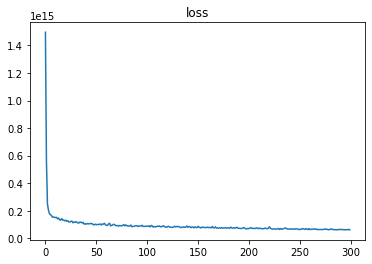

In [18]:
class CaptchaModel(nn.Module):
    """
    network, model and guide wrapper class
    """
    def __init__(self, use_cuda=False):
        super().__init__()
        self.noiseNet = NoiseAlphaNet((captchaHeight, captchaWidth), 1)
        self.alphaNet = NoiseAlphaNet((captchaHeight, captchaWidth), 1)
        self.noiseChannelExtract = NoiseChannelExtract((captchaHeight, captchaWidth))
        self.charChannelExtract = ChannelExtract((captchaHeight, captchaWidth))
        self.char_dict = char_dict # letter dictionary
        self.charNet = CharNetSingle((captchaHeight, captchaWidth), len(self.char_dict), MAX_N) # with noise
        self.noise_constraint = torch.distributions.constraints.interval(MIN_NOISE, MAX_NOISE)
        self.alpha_constraint = torch.distributions.constraints.interval(blend_alpha_min, blend_alpha_max)
        self.hid_net = simpleNN(hidden_state_dim + len(char_dict) + MAX_N, hidden=128, out_size = hidden_state_dim, t = "mlp")
        self.h0 = nn.Parameter(torch.zeros(hidden_state_dim))
        self.noise_dim = 64
            
        if use_cuda:
            self.cuda()
        self.use_cuda = use_cuda
    
    def _map_to_noise_range(self, input):
        """
        map input number to the valid noise range
        """
        input = torch.distributions.transform_to(self.noise_constraint)(input)
        return input
    
    def _map_to_alpha_range(self, input):
        input = torch.distributions.transform_to(self.alpha_constraint)(input)
        return input

    # update from old captcha model/guide:
    # using mask to zero out index > num_char, this is a generalization of the previous version where we take the mean 
    # and assume num_char is the same for the entire batch

    def guide(self, observations={"captcha": torch.rand(1, captchaHeight, captchaWidth)}):
        pyro.module("guide", self)
        img = observations["captcha"].float()
        BS = img.shape[0]
        
        with pyro.plate("data", img.shape[0]):
            
            alpha_mean, alpha_sig, _ = self.alphaNet(img)
            alpha = pyro.sample("alpha", dist.Normal(alpha_mean, alpha_sig).to_event(1))
            
            charChannel_mean, charChannel_sig = self.charChannelExtract(img, alpha)
            charChannel = pyro.sample("char_channel", dist.Normal(charChannel_mean, charChannel_sig).to_event(2))
            noiseChannel_mean, noiseChannel_sig = self.noiseChannelExtract(img, alpha)
            noiseChannel = pyro.sample("noise_channel", dist.Normal(noiseChannel_mean, noiseChannel_sig).to_event(2))
            noise_mean, noise_sig, noise_map = self.noiseNet(noiseChannel)
            noise_batch = pyro.sample("noise", dist.Normal(noise_mean, noise_sig).to_event(1))
            noise_batch = self._map_to_noise_range(noise_batch)
            h = self.h0.expand(BS, -1)
            
            for i in range(MAX_N):
                # tranform index to one-hot representation
                i_input = torch.tensor(i)
                if USE_CUDA:
                    i_input = i_input.cuda()
                i_input = F.one_hot(i_input, num_classes=MAX_N).float()
                i_input = i_input.repeat(BS, 1)
                charP_i = self.charNet(charChannel, h, noise_batch)
                c_i = pyro.sample("char_{}".format(i), dist.Categorical(charP_i).to_event(0))
                c_i = F.one_hot(c_i, num_classes=len(self.char_dict)).float()
                # update the hidden state
                h = self.hid_net([h, c_i, i_input])

    def model_rec(self, observations={"captcha": torch.rand(1, captchaHeight, captchaWidth)}):
        
        BS = observations["captcha"].shape[0]
        
        with pyro.plate("data", BS):
            
            alpha_mean = torch.tensor((blend_alpha_min - blend_alpha_max) / 2).repeat((BS, 1))
            alpha_sig = torch.tensor(0.5).repeat((BS, 1))
            if self.use_cuda:
                alpha_mean = alpha_mean.cuda()
                alpha_sig = alpha_sig.cuda()
            alpha = pyro.sample("alpha", dist.Normal(alpha_mean, alpha_sig).to_event(1))
            
            noise_mean = torch.tensor((MAX_NOISE - MIN_NOISE) / 2).repeat((BS, 1))
            noise_sig = torch.tensor(0.5).repeat((BS, 1))
            if self.use_cuda:
                noise_mean = noise_mean.cuda()
                noise_sig = noise_sig.cuda()
            noise_batch = pyro.sample("noise", dist.Normal(noise_mean, noise_sig).to_event(1))
            noise_batch = self._map_to_noise_range(noise_batch)
            
            sampled_c = []
            
            def _rec(i):
                if i < MAX_N:
                    num_c_i = torch.tensor(1 / len(self.char_dict)).repeat((BS, len(self.char_dict)))
                    if self.use_cuda:
                        num_c_i = num_c_i.cuda()
                    c_i = pyro.sample("char_{}".format(i), dist.Categorical(num_c_i).to_event(0))
                    sampled_c.append(c_i)
                    _rec(i + 1)
            _rec(0)
                
            # sample characters
            rendered_char_channels = []
            
            # does not contain any sample statements
            def _render_imgs(i):
                
                def _get_chars(j, chars, i):
                    if j < MAX_N:
                        chars += self.char_dict[sampled_c[j][i]]
                        return _get_chars(j + 1, chars, i)
                    return chars
    
                if i < BS:
                    chars = _get_chars(0, "", i)
                    rendered_char_channel = render_image(chars, noise=0., use_cuda=self.use_cuda)
                    rendered_char_channels.append(rendered_char_channel)
                    _render_imgs(i + 1)
                    
            _render_imgs(0)
            
            rendered_char_channels = torch.stack(rendered_char_channels)
            noise_channel_loc = noise_batch.unsqueeze(2).repeat(1, captchaHeight, captchaWidth)
            noise_channel_sig = noise_sig.unsqueeze(2).repeat(1, captchaHeight, captchaWidth)
            sigma = torch.tensor(0.0001)
            if self.use_cuda:
                sigma = sigma.cuda()
            
            noise_channels = pyro.sample("noise_channel", dist.Normal(1 - noise_channel_loc, noise_channel_sig).to_event(2))
            char_channels = pyro.sample("char_channel", dist.Normal(rendered_char_channels, sigma).to_event(2))
            
        noise_channels = noise_channels - 0.5
        alpha = alpha.unsqueeze(-1).repeat(1, char_channels.shape[1], char_channels.shape[2])
        blended_image = alpha  * char_channels + (1- alpha) * noise_channels
        
        sigma_obs = torch.tensor(0.000001)
        if self.use_cuda:
                sigma_obs = sigma_obs.cuda()

        pyro.sample("captcha", dist.Normal(blended_image, sigma_obs).to_event(2), obs=observations["captcha"])

captchaModel = CaptchaModel(USE_CUDA)

optimiser = pyro.optim.Adam({'lr': 5e-5})
csis = pyro.infer.CSIS(captchaModel.model_rec, captchaModel.guide, optimiser, num_inference_samples=1)

optimize(1, USE_CUDA)
# test_cycle(USE_CUDA)
save_metric_to_disk("captcha_metrics_mixture_large_manual.json")


Logs